<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Sparsity and Sparse Coding

**Week 1, Day 5: Microcircuits**

**By Neuromatch Academy**

__Content creators:__ Noga Mudrik, Xaq Pitkow

__Content reviewers:__ Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 2 hours*

In this tutorial we will discuss the notion of sparsity. In particular, we will:

- Recognize various types of sparsity (population, lifetime, interaction).
- Relate sparsity to inductive bias, interpretability, and efficiency.


In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "cp57z"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

---
# Setup



In [ ]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W1D5_T1"

In [ ]:
# Imports

#working with data
import numpy as np
import pandas as pd
from scipy.stats import kurtosis

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import logging

#interactive display
import ipywidgets as widgets
from tqdm.notebook import tqdm as tqdm

#modeling
from sklearn.datasets import make_sparse_coded_signal, make_regression
from sklearn.decomposition import DictionaryLearning, PCA
from sklearn.linear_model import OrthogonalMatchingPursuit

#utils
import os

In [ ]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True
sns.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting functions

def remove_edges(ax, include_ticks = True, top = False, right = False, bottom = True, left = True):
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    if not include_ticks:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

def add_labels(ax, xlabel='X', ylabel='Y', zlabel='', title='', xlim = None, ylim = None, zlim = None,xticklabels = np.array([None]),
               yticklabels = np.array([None] ), xticks = [], yticks = [], legend = [],
               ylabel_params = {'fontsize':19},zlabel_params = {'fontsize':19}, xlabel_params = {'fontsize':19},
               title_params = {'fontsize':29}, format_xticks = 0, format_yticks = 0):
  """
  This function add labels, titles, limits, etc. to figures;
  Inputs:
      ax      = the subplot to edit
      xlabel  = xlabel
      ylabel  = ylabel
      zlabel  = zlabel (if the figure is 2d please define zlabel = None)
      etc.
  """
  if xlabel != '' and xlabel != None: ax.set_xlabel(xlabel, **xlabel_params)
  if ylabel != '' and ylabel != None:ax.set_ylabel(ylabel, **ylabel_params)
  if zlabel != '' and zlabel != None:ax.set_zlabel(zlabel,**zlabel_params)
  if title != '' and title != None: ax.set_title(title, **title_params)
  if xlim != None: ax.set_xlim(xlim)
  if ylim != None: ax.set_ylim(ylim)
  if zlim != None: ax.set_zlim(zlim)

  if (np.array(xticklabels) != None).any():
      if len(xticks) == 0: xticks = np.arange(len(xticklabels))
      ax.set_xticks(xticks);
      ax.set_xticklabels(xticklabels);
  if (np.array(yticklabels) != None).any():
      if len(yticks) == 0: yticks = np.arange(len(yticklabels)) +0.5
      ax.set_yticks(yticks);
      ax.set_yticklabels(yticklabels);
  if len(legend)       > 0:  ax.legend(legend)

def plot_signal(signal, title = "Pixel's activity over time", ylabel = '$pixel_t$'):
    """
    Plot the given signal over time.

    Inputs:
    - signal (np.array): given signal.
    - title (str, default = "Pixel's activity over time"): title to give to the plot.
    - ylabel (str, default = '$pixel_t$'): y-axis label.
    """
    with plt.xkcd():
        fig, ax = plt.subplots(1,1, figsize = (30,10), sharex = True)
        ax.plot(signal, lw = 5)
        ax.set_xlim(left = 0)
        ax.set_ylim(bottom = 0)
        add_labels(ax, xlabel = 'Time (Frames)',ylabel = ylabel, title = title)
        remove_edges(ax)
    plt.show()

def plot_relu_signal(signal, theta = 0):
    """
    Plot the given signal over time and its thresholded value with the given theta.

    Inputs:
    - signal (np.array): given signal.
    - theta (float, default = 0): threshold parameter.
    """
    with plt.xkcd():
        fig, ax = plt.subplots(1,1, figsize = (30,10), sharex = True)
        ax.plot(sig, lw = 5)
        thres_x = ReLU(signal, theta)
        ax.plot(thres_x, lw = 5)
        ax.set_xlim(left = 0)
        ax.legend(['Signal', '$ReLU_{%d}$(signal)'%theta], ncol = 2)
        add_labels(ax, xlabel = 'Time', ylabel = 'Signal')
        remove_edges(ax)
    plt.show()

def plot_relu_histogram(signal, theta = 0):
    """
    Plot histogram of the values in the signal before and after applying ReLU operation with the given threshold.

    Inputs:
    - signal (np.array): given signal.
    - theta (float, default = 0): threshold parameter.
    """
    with plt.xkcd():
        fig, axs = plt.subplots(1,2,figsize = (15,10), sharex = True, sharey = True)
        thres_x = ReLU(signal, theta)
        axs[0].hist(sig, bins = 100)
        axs[1].hist(thres_x, bins = 100)
        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        [ax.set_title(title) for title, ax in zip(['Before Thresholding', 'After Thresholding'], axs)]
    plt.show()

def plot_relu_signals(signal, theta_values):
    """
    Plot the given signal over time and its thresholded value with the given theta values.

    Inputs:
    - signal (np.array): given signal.
    - theta_values (np.array): threshold parameter.
    """
    #define colormap
    cmap_name = 'viridis'
    samples = np.linspace(0, 1, theta_values.shape[0])
    colors = plt.colormaps[cmap_name](samples)

    fig, ax = plt.subplots(1,1, figsize = (30,10), sharex = True)
    for counter, theta in enumerate(theta_values):
      ax.plot(ReLU(signal, theta), label = '$\\theta = %d$'%theta, color = colors[counter])
    ax.set_xlim(left = 0)
    ax.legend(ncol = 5)
    add_labels(ax, xlabel = 'Time', ylabel = '$ReLU_{\\theta}$(Signal)')
    remove_edges(ax)

def plot_kurtosis(signal, theta_values):
    """
    Plot kurtosis value for the signal before and after applying ReLU operation with the given threshold values.

    Inputs:
    - signal (np.array): given signal.
    - theta_values (np.array): array of threshold parameters.
    """
    with plt.xkcd():
        fig, ax = plt.subplots()
        relus = [kurtosis(ReLU(signal, theta)) for theta in theta_values]
        pd.DataFrame([kurtosis(signal)] + relus, index = ['Signal']+ ['$ReLU_{%d}$(signal)'%theta for theta in theta_values], columns = ['kurtosis']).plot.bar(ax = ax, alpha = 0.5, color = 'purple')
        remove_edges(ax)
    plt.show()

def plot_images(images):
    """
    Plot given images.

    Inputs:
    - images (list): list of 2D np.arrays which represent images.
    """
    with plt.xkcd():
        fig, ax = plt.subplots(1, len(images), figsize = (20,8))
        if len(images) == 1:
            ax.imshow(images[0])
        else:
            for index, image in enumerate(images):
                ax[index].imshow(image)
    plt.show()

def plot_labeled_kurtosis(frame, frame_HT, labels = ['Frame', 'HT(frame)']):
    """
    Plot kurtosis value for the frame before and after applying hard threshold operation.

    Inputs:
    - frame (np.array): given image.
    - frame_HT (np.array): thresholded version of the given image.
    - labels (list): list of labels to apply for the igven data.
    """
    with plt.xkcd():
        fig, ax = plt.subplots()
        pd.DataFrame([kurtosis(frame.flatten()), kurtosis(frame_HT.flatten())],index = labels, columns = ['kurtosis']).plot.bar(ax = ax, alpha = 0.5, color = 'purple')
        remove_edges(ax)
    plt.show()

def plot_temporal_difference_histogram(signal, temporal_diff):
    """
    Plot histogram for the values of the given signal as well as for its temporal differenced version.

    Inputs:
    - signal (np.array): given signal.
    - temporal_diff (np.array): temporal differenced version of the signal.
    """
    with plt.xkcd():
        fig, axs = plt.subplots(1,2,figsize = (15,5), sharex = True, sharey = True)
        axs[0].hist(signal, bins = 100);
        axs[1].hist(temporal_diff, bins = 100);
        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        [ax.set_title(title) for title, ax in zip(['Pixel \n Before Diff.', 'Frame \n After Diff.'], axs)]
    plt.show()

def plot_temp_diff_histogram(signal, taus, taus_list):
    """
    Plot the histogram for the given signal over time and its temporal differenced versions for different values of lag \tau.

    Inputs:
    - signal (np.array): given signal.
    - taus (np.array): array of tau values (lags).
    - taus_list (list): temporal differenced versions of the given signal.
    """
    #define colormap
    cmap_name = 'cool'
    samples = np.linspace(0, 1, taus.shape[0])
    colors = plt.colormaps[cmap_name](samples)

    with plt.xkcd():

        # histograms
        bin_edges = np.arange(0, 256, 5)  # Define bin edges from 0 to 255 with a step of 5

        # Compute histogram values using custom bin edges
        hist = [np.histogram(tau_list, bins=bin_edges)[0] for tau, tau_list in zip(taus, taus_list)]


        fig, ax = plt.subplots(figsize = (20,5))
        [ax.plot(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.vstack(hist)[j], marker = 'o', color = colors[j], label = '$\\tau = %d$'%taus[j]) for j in range(len(taus))]
        ax.legend(ncol = 2)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = '$\\tau$', ylabel = 'Count')
    plt.show()

def plot_temp_diff_separate_histograms(signal, lags, lags_list, tau = True):
    """
    Plot the histogram for the given signal over time and its temporal differenced versions for different values of lag \tau or windows.

    Inputs:
    - signal (np.array): given signal.
    - lags (np.array): array of lags (taus or windows).
    - lags_list (list): temporal differenced versions of the given signal.
    - tau (bool, default = True): which regime to use (tau or window).
    """
    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, taus.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        fig, axs = plt.subplots(2, int(0.5*(2+lags.shape[0])),figsize = (25,19), sharex = True, sharey = False)
        axs = axs.flatten()
        axs[0].hist(signal, bins = 100, color = 'black');

        if tau:
            # histograms
            bin_edges = np.arange(0, 256, 5)  # Define bin edges from 0 to 255 with a step of 5

            # Compute histogram values using custom bin edges
            hist = [np.histogram(lag_list, bins=bin_edges)[0] for lag, lag_list in zip(lags, lags_list)]

            [axs[j+1].bar(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.abs( np.vstack(hist)[j]), color = colors[j]) for j in range(len(lags))]

        else:
            [axs[j+1].hist(np.abs(signal - ema_values_i), bins = 100, color = colors[j]) for j, ema_values_i in enumerate(lags_list)]

        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        axs[0].set_title('Pixel \n Before Diff.');
        if tau:
            [ax.set_title( '$\\tau$ %.2f'%lags[j]) for  j, ax in enumerate(axs[1:]) if j < lags.shape[0]]
        else:
            [ax.set_title( 'Window %d'%lags[j]) for  j, ax in enumerate(axs[1:]) if j < lags.shape[0]]
    plt.show()

def plot_temp_diff_kurtosis(signal, lags, lags_list, tau = True):
    """
    Plot the kurtosis for the given signal over time and its temporal differenced versions for different values of lag \tau or windows.

    Inputs:
    - signal (np.array): given signal.
    - lags (np.array): array of lags (taus or windows).
    - lags_list (list): temporal differenced versions of the given signal.
    - tau (bool, default = True): which regime to use (tau or window).
    """
    with plt.xkcd():
        if tau:
            fig, ax = plt.subplots(figsize = (10,3))
            tauskur = [kurtosis(tau_i) for tau_i in lags_list]
            pd.DataFrame([kurtosis(signal)] + tauskur, index = ['Signal']+ ['$\\tau = {%d}$'%tau for tau in lags], columns = ['kurtosis']).plot.barh(ax = ax, alpha = 0.5, color = 'purple')
            remove_edges(ax)
        else:
            fig, ax = plt.subplots(figsize = (7,7))
            tauskur = [kurtosis(np.abs(signal - ema_values_i)) for ema_values_i in lags_list]
            pd.DataFrame([kurtosis(signal)] + tauskur, index = ['Signal']+ ['$window = {%d}$'%tau for tau in lags], columns = ['kurtosis']).plot.bar(ax = ax, alpha = 0.5, color = 'purple')
            remove_edges(ax)

def plot_ema(signal, window, ema_signal):
    """
    Plot signal, the window function and the resulted convolution.

    Inputs:
    - signal (np.array): the given signal.
    - window (int): size of the window function.
    - ema_signal (np.array): the resulted signal.
    """
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()

    with plt.xkcd():
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
            ax[0].plot(signal)
            ax[0].set_title('Signal')
            ax[1].plot(weights)
            ax[1].set_title('Window Function')
            ax[2].plot(ema_signal)
            ax[2].set_title('EMA Signal')
            plt.subplots_adjust(wspace=0.3)
    plt.show()

def plot_diff_with_ema(signal, windows, ema_values):
    """
    Plot difference between given signal and EMA ones for different windows.

    Inputs:
    - signal (np.array): given signal.
    - windows (np.array): list of window sizes.
    - ema_values (list): list for EMA versions of the signal.
    """
    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, windows.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        fig, ax = plt.subplots(figsize = (20,10))
        ax.plot(signal, label = "Signal")
        [ax.plot(signal - ema_values_i, color = colors[j], label = 'window = %d'%windows[j]) for j, ema_values_i in enumerate(ema_values)]
        ax.legend(ncol = 4)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = 'Time (frame)', ylabel = '$\Delta(pixel)$')
    plt.show()

def plot_spatial_diff(frame, diff_x,  diff_y):
    """
    Plot spatial differentiation of the given image with lag one.

    Inputs:
    - frame (np.array): given 2D signal (image).
    - diff_x (np.array): spatial difference along x-axis.
    - diff_y (np.array): spatial difference along y-axis.
    """

    with plt.xkcd():
        fig, axs = plt.subplots(1,3, figsize = (50,10))
        diff_x_norm = (diff_x - np.percentile(diff_x, 10))/(np.percentile(diff_x, 90) - np.percentile(diff_x, 10))
        diff_x_norm = diff_x_norm*255
        diff_x_norm[diff_x_norm > 255] = 255
        diff_x_norm[diff_x_norm < 0] = 0
        axs[0].imshow(diff_x_norm.astype(np.uint8))
        diff_y_norm = (diff_y - np.percentile(diff_y, 10))/(np.percentile(diff_y, 90) - np.percentile(diff_y, 10))
        diff_y_norm = diff_y_norm*255
        diff_y_norm[diff_y_norm > 255] = 255
        diff_y_norm[diff_y_norm < 0] = 0
        axs[1].imshow(diff_y_norm.astype(np.uint8))
        axs[2].imshow(frame)
        [ax.set_xticks([]) for ax in axs]
        [ax.set_yticks([]) for ax in axs]
        [ax.set_title(title, fontsize = 40) for title, ax in zip(['$\Delta x$', '$\Delta y$', 'Original'], axs)];

def plot_spatial_diff_histogram(taus, taus_list_x, taus_list_y):
    """
    Plot histograms for each of the spatial differenced version of the signal.
    """

    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, taus.shape[0])
        colors = plt.colormaps[cmap_name](samples)

        # histograms (built in solution)

        bin_edges = np.arange(0, 256, 5)  # Define bin edges from 0 to 255 with a step of 5

        hist_x = [np.histogram(tau_list.flatten() ,  bins=bin_edges)[0] for tau, tau_list in zip(taus, taus_list_x )]
        hist_y = [np.histogram(tau_list.flatten(),  bins=bin_edges)[0] for tau, tau_list in zip(taus, taus_list_y)]

        fig, axs = plt.subplots(2,1,figsize = (20,9))
        ax = axs[0]
        [ax.plot(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.vstack(hist_x)[j], marker = 'o', color = colors[j], label = '$\\tau = %d$'%taus[j]) for j in range(len(taus))]
        ax.set_yscale('log')
        ax.legend(ncol = 2)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = '$\\tau_x$', ylabel = 'Count', title = 'Diff. in $x$')

        ax = axs[1]
        [ax.plot(bin_edges[:-1]*0.5 + bin_edges[1:]*0.5, np.vstack(hist_y)[j], marker = 'o', color = colors[j], label = '$\\tau = %d$'%taus[j]) for j in range(len(taus))]
        ax.set_yscale('log')
        ax.legend(ncol = 2)
        remove_edges(ax)
        ax.set_xlim(left = 0, right = 100)
        add_labels(ax, xlabel = '$\\tau_y$', ylabel = 'Count', title = 'Diff. in $y$')

        fig.tight_layout()
    plt.show()

def plot_spatial_kurtosis(signal, diff_x, diff_y):
    """
    Plot kurtosis for the signal and its spatial differenced version.
    """
    with plt.xkcd():
        fig, ax = plt.subplots()
        pd.DataFrame([kurtosis(sig.flatten()), kurtosis(diff_x.flatten()), kurtosis(diff_y.flatten())],index = ['Signal', 'Diff $x$', 'Diff $y$'], columns = ['kurtosis']).plot.barh(ax = ax, alpha = 0.5, color = 'purple')
        remove_edges(ax)
    plt.show()

def plot_spatial_histogram(frame, diff_x, diff_y):
    """
    Plot histogram for values in frame and differenced versions.
    """
    with plt.xkcd():
        fig, axs = plt.subplots(1,3,figsize = (25,10), sharex = True, sharey = True)
        axs[0].hist(np.abs(frame.flatten()), bins = 100);
        axs[1].hist(np.abs(diff_x.flatten()), bins = 100);
        axs[2].hist(np.abs(diff_y.flatten()), bins = 100);
        [remove_edges(ax) for ax in axs]
        [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
        [ax.set_title(title) for title, ax in zip(['Frame \n Before Diff.', 'Frame \n After Diff. x', 'Frame \n After Diff. x'], axs)]

def visualize_images_ema(frame, ema_values_x, ema_values_y):
    """
    Plot images with EMA difference method.
    """
    with plt.xkcd():
        cmap_name = 'cool'
        samples = np.linspace(0, 1, num_winds)
        colors = plt.colormaps[cmap_name](samples)
        fig, axs = plt.subplots( 2, int(0.5*(2+ len(ema_values_x))),  figsize = (50,15))
        axs = axs.flatten()
        axs[0].imshow(frame)
        [axs[j+1].imshow(normalize(frame - ema_values_i)) for j, ema_values_i in enumerate(ema_values_x)]
        remove_edges(axs[-1], left = False, bottom = False, include_ticks=  False)
        fig.suptitle('x diff')

        fig, axs = plt.subplots( 2, int(0.5*(2+ len(ema_values_x))),  figsize = (50,15))
        axs = axs.flatten()
        axs[0].imshow(frame)
        [axs[j+1].imshow(normalize(frame.T - ema_values_i).T) for j, ema_values_i in enumerate(ema_values_y)]
        remove_edges(axs[-1], left = False, bottom = False, include_ticks=  False)
        fig.suptitle('y diff')

def create_legend(dict_legend, size = 30, save_formats = ['.png','.svg'],
                      save_addi = 'legend' , dict_legend_marker = {},
                      marker = '.', style = 'plot', s = 500, plot_params = {'lw':5},
                      params_leg = {}):
    fig, ax = plt.subplots(figsize = (5,5))
    if style == 'plot':
        [ax.plot([],[],
                     c = dict_legend[area], label = area, marker = dict_legend_marker.get(area), **plot_params) for area in dict_legend]
    else:
        if len(dict_legend_marker) == 0:
            [ax.scatter([],[], s=s,c = dict_legend.get(area), label = area, marker = marker, **plot_params) for area in dict_legend]
        else:
            [ax.scatter([],[], s=s,c = dict_legend[area], label = area, marker = dict_legend_marker.get(area), **plot_params) for area in dict_legend]
    ax.legend(prop = {'size':size},**params_leg)
    remove_edges(ax, left = False, bottom = False, include_ticks = False)

In [ ]:
# @Helper functions
def normalize(mat):
  mat_norm = (mat - np.percentile(mat, 10))/(np.percentile(mat, 90) - np.percentile(mat, 10))
  mat_norm = mat_norm*255
  mat_norm[mat_norm > 255] = 255
  mat_norm[mat_norm < 0] = 0
  return mat_norm

In [ ]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fnames = ["frame1.npy", "sig.npy", "reweight_digits.npy"] # The names of the files to be downloaded
urls = ["https://osf.io/n652y/download", "https://osf.io/c9qxk/download", "https://osf.io/ry5am/download"] # URLs from where the files will be downloaded
expected_md5s = ["6ce619172367742dd148cc5830df908c", "f3618e05e39f6df5997f78ea668f2568", "1f2f3a5d08e13ed2ec3222dca1e85b60"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

In [ ]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)

set_seed(seed = 42)

---

# Section 1: Natural sparsity

Under what secnarios do we get sparsity in real life? In the first section, we will explore different ways to achieve sparsity in real-world signals.

In [ ]:
# @title Video 1: Introduction to sparsity

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'TQdxKttMYlc')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Coding Exercise 1

In this exercise, we will understand causes of sparsity by measuring sparsity under different operations:
nonlinearity, e.g. thresholding. We will create temporal sparsity in 1D time series (e.g. piecewise constant) by feedforward inhibition (or temporal differencing) as well as we will create population sparsity by lateral inhibition on images.

For the first exercise, we will focus on a video of a bird in San Fransisco, and extract both temporal and spatial sparsity
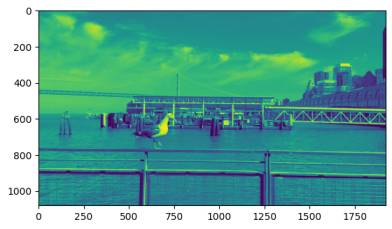

for the temporal sparsity, we will focus on the activity of a specific pixel over time (Frames)

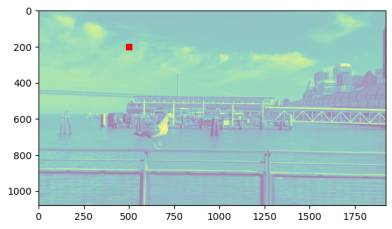




At first, we are going to load the prepared data and visualize the signal!

In [ ]:
#make sure you've downloaded these files in `Data retrieval` cell

sig = np.load('sig.npy')
plot_signal(sig)

### Coding Exercise 1A: Sparsify a natural signal

Write a function called "**ReLU**" that receives 2 inputs:

1) $x$ - a 1-d numpy array of $p$ floats.

2) $\theta$ - a scalar.

The function should return a numpy array called `thres_x` such that:

$$
\text{thres-x}_j =
\begin{cases}
x_j - \theta & \text{if } x_j \geq \theta \\
0 & \text{otherwise}
\end{cases}
$$
for every element $j\in [1,J]$.

Apply the ReLU  function to the signal "**sig**" with a threshold of $\theta =  150$.

```python
def ReLU(x, theta = 0):
    """
    Calculates ReLU function for the given level of theta.

    Inputs:
    - x (np.ndarray): input data.
    - theta (float, default = 0): threshold parameter.

    Outputs:
    - thres_x (np.ndarray): filtered values.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete `thres_x` array calculation as defined.")
    ###################################################################

    thres_x = ...

    return thres_x

plot_relu_signal(sig, theta = 150)

```

In [ ]:
#to_remove solution
def ReLU(x, theta = 0):
    """
    Calculates ReLU function for the given level of theta.

    Inputs:
    - x (np.ndarray): input data.
    - theta (float, default = 0): threshold parameter.

    Outputs:
    - thres_x (np.ndarray): filtered values.
    """

    thres_x = np.maximum(x - theta, 0)

    return thres_x

plot_relu_signal(sig, theta = 150)

Finally, let's calculate kurtosis value for the signal and its version passed through the ReLU function.

In [ ]:
plot_kurtosis(sig, theta_values = np.array([150]))

### Coding Exercise 1B: Effect of increasing thresholding

Gradually increase the thresholding ($\theta$) from 0 to 250 in intervals of 20 and plot the result for each value.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calculation of theta values.")
###################################################################

step = ...
theta_values = ...

plot_relu_signals(sig ,theta_values)

```

In [ ]:
#to_remove solution

step = 20
theta_values = np.arange(0, 250, step)

plot_relu_signals(sig ,theta_values)

In [ ]:
plot_kurtosis(sig, theta_values)

# Section 2: Sparsity in space

Estimated timing to here from start of tutorial: 20 minutes.

So far, we focused on temporal sparsity. Now, we will define a ``hard_thresholding" operator. Specifically, we will focus on a single frame of the video (the 1st frame) and apply hard thresholding to it to explore the effect.

In [ ]:
# @title Video 2: Sparsity in space

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'ylKP9s8qqYY')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Coding Excercise 2

At first, let us load the signal we are going to use and observe it as image.

In [ ]:
#make sure you've downloaded these files in `Data retrieval` cell

frame = np.load('frame1.npy')
plot_images([frame])

### Coding Exercise 2A: Applying Hard Thresholding

So far, we focused on applying ReLU, which can also be considered as a form of **'soft thresholding'**. Now, we will apply a different kind of thresholding, called **hard thresholding**.

Here, you will have to write a function called **hard_thres** that receives 2 inputs:

1) frame - 2d array as input of $p \times p$ floats.

2) theta - threshold scalar values.

The function has to return a 2d array called **frame_HT** with the same dimensions as of **frame**, however, all values smaller than $\theta$ need to be set to 0, i.e.:
 $$
\text{frame-HT}_{[i,j]} =
\begin{cases}
frame_{[i,j]} & \text{if } frame_{[i,j]} \geq \theta \\
0 & \text{otherwise}
\end{cases}
$$
for every pixel [i,j] in frame.

```python
def hard_thres(frame, theta):
    """
    Return hard thresholded array of values based on the parameter value theta.

    Inputs:
    - frame (np.array): 2D signal.
    - theta (float, default = 0): threshold parameter.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete `frame_HT` array calculation as defined.")
    ###################################################################
    frame_HT = ...
    frame_HT[...] = ...
    return frame_HT

frame_HT = hard_thres(frame, 150)
plot_images([frame, frame_HT])

```

In [ ]:
#to_remove solution
def hard_thres(frame, theta):
    """
    Return hard thresholded array of values based on the parameter value theta.

    Inputs:
    - frame (np.array): 2D signal.
    - theta (float, default = 0): threshold parameter.
    """
    frame_HT = frame.copy()
    frame_HT[frame_HT < theta] = 0
    return frame_HT

frame_HT = hard_thres(frame, 150)
plot_images([frame, frame_HT])

Notice how many pixels became of the same violet color - those are the thresholded ones.

### Coding Exercise 2B: Percentile Threshold

Define the variable **frame_HT** as the first frame after the hard threshold operator, using the above **hard_thres** function with threshold of 80% of the frame values.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete search of the pixel value which corresponds to 80-percentile and calculate thresholded version of the image.")
###################################################################
low_perc = np.percentile(..., ...)
frame_HT = hard_thres(..., ...)
plot_images([frame, frame_HT])

```

In [ ]:
#to_remove solution
low_perc = np.percentile(frame, 80)
frame_HT = hard_thres(frame, low_perc)
plot_images([frame, frame_HT])

### Coding Execrcise 2C: Explore the effect of hard thresholding using the values histogram

We will now explore the differences before and after applying hard thresholding, using the histogram. Generate a histogram for the frame_HT. It might take a while as image is of high quality and it contains a lot of pixels.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete histogram plot.")
###################################################################

with plt.xkcd():
    fig, axs = plt.subplots(1,2,figsize = (15,5), sharey = True)
    axs[0].hist(frame.flatten(), bins = 100);
    axs[1].hist(..., bins = 100);

    #utils
    [ax.set_yscale('log') for ax in axs]
    [remove_edges(ax) for ax in axs]
    [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
    [ax.set_title(title) for title, ax in zip(['Before Thresholding', 'After Thresholding'], axs)]

```

In [ ]:
#to_remove solution
with plt.xkcd():
    fig, axs = plt.subplots(1,2,figsize = (15,5), sharey = True)
    axs[0].hist(frame.flatten(), bins = 100);
    axs[1].hist(frame_HT.flatten(), bins = 100);

    #utils
    [ax.set_yscale('log') for ax in axs]
    [remove_edges(ax) for ax in axs]
    [add_labels(ax, ylabel = 'Count', xlabel = 'Value') for ax in axs]
    [ax.set_title(title) for title, ax in zip(['Before Thresholding', 'After Thresholding'], axs)]

Let us also take a look at the kurtosis.

In [ ]:
plot_labeled_kurtosis(frame, frame_HT)

# Section 3: Temporal differentiation

Estimated timing to here from start of tutorial: 35 minutes.


In [ ]:
# @title Video 3: Temporal differentiation

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JwltmHZzIYg')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Coding Exercise 3

Now, we will focus on the temporal differences of a natural signal. Particularly, let the pixel value at time $t$ be $pixel_t$ for all $t = 1\dots T$. We look on:
$$\Delta(pixel_t) = pixel_t - pixel_{t-1} \quad  \forall \quad t = 2\dots T$$

How do you think the temporal different of a natural signal will look like? 

In this exercise, you will have to look on the temporal differentaition of a natural signal and quantify its sparsity. We will return back to the already defined pixel signal `sig`.



### Coding Exercise 3A: Temporal differencing signal 

Define a temporal differencing signal (abs. value) called **temporal_diff**. You can use the built-in *diff* function of numpy.


```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete temporal differentiation.")
###################################################################
# define temporal_diff
temporal_diff = ...
plot_signal(temporal_diff, title = "", ylabel = "$| pixel_t - pixel_{t-1} | $")

```

In [ ]:
#to_remove solution
# define temporal_diff
temporal_diff = np.abs(np.diff(sig))
plot_signal(temporal_diff, title = "", ylabel = "$| pixel_t - pixel_{t-1} | $")

Let's take a look on the histogram of the temporal differences values as well as kurtosis values.

In [ ]:
plot_temporal_difference_histogram(sig, temporal_diff)

In [ ]:
plot_labeled_kurtosis(sig, temporal_diff, labels = ['Signal', 'Temporal \n Diff.'])

### Coding Exercise 3B: Increasing the temporal differcing intervals

So far, we focused on single intervals, i.e. $\Delta_t = pixel_t - pixel_{t-1}$.

What happen if we look on longer-scale differences? I.e. $$\Delta_t(\tau) = pixel_t - pixel_{t-\tau}$$ for some $\tau > 1$?

In this exercise, we will explore the effects of increasing $\tau$ values on the sparsity of the temporal differentiation signal.

1) Create an array of 10 different $\tau$ values: $taus = [1, 11, 21... , 91]$.

2) Create a list called **taus_list** composed of of 10 arrays where the $j$-th array is the temporal differetiation with an interval equal to the $j$-th $\tau$.

3) Plot a heatmap that compares the histograms of the different taus.

Pay attention: here, it is NOT recommended to use to built-in `diff` function.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `taus` and `taus_list`.")
###################################################################
num_taus = 10

# create taus
taus = ...

# create taus_list
taus_list = ...

plot_temp_diff_histogram(sig, taus, taus_list)

```

In [ ]:
#to_remove solution
num_taus = 10

# create taus
taus = np.linspace(1,91,num_taus).astype(int)

# create taus_list
taus_list = [np.abs(sig[tau:] - sig[:-tau]) for tau in taus]

plot_temp_diff_histogram(sig, taus, taus_list)

Now, let us take a look at the histograms for each $\tau$ separately as well as for kurtosis values.

In [ ]:
plot_temp_diff_separate_histograms(sig, taus, taus_list)

In [ ]:
plot_temp_diff_kurtosis(sig, taus, taus_list)

### Coding Exercise 3C: Increasing the temporal differencing intervals using Exponential Moving Average (EMA)

At first let's define `ema` function which takes signal and the size of the window as inputs. What is does under the hood is the simple convolution between signal and exponential window, where its size defines the actual size of the array we are going to convolve our function on. Observe the results visually for `window = 10`. We will do temporal difference as the difference between raw signal and its EMA version for different values of windows.

In [ ]:
def ema(data, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    ema = np.convolve(data, weights, mode='full')[:len(data)]
    ema[:window] = ema[window]
    return ema

window = 10
ema_signal = ema(sig, window)
plot_ema(sig, window, ema_signal)

Now, define the window for 10 different values: `windows = [1,11,21,...91]` and calculate corresponding `EMA` versions of the signal.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `windows` and `ema_values`.")
###################################################################
windows = ...
ema_values = ...

```

In [ ]:
#to_remove solution
windows = np.linspace(1, 91, 10)
ema_values = [ema(sig, int(window)) for window in windows]

Now, let's take a look at the temporal differenced versions of filtered signals as well as for separate histograms and kurtosis values.

In [ ]:
plot_diff_with_ema(sig, windows, ema_values)

In [ ]:
plot_temp_diff_separate_histograms(sig, windows, ema_values, tau = False)

In [ ]:
plot_temp_diff_kurtosis(sig, windows, ema_values, tau = False)

# Section 4: Spatial Differentiation

Estimated timing to here from start of tutorial: 1 hour.

## Coding Exercise 4

Now we will focus on spatial differentiation.
Spatial differeitation is common in identifying image patterns and extract meaningful features.
Let's apply it on the 1st frame to look on the result (meaning we return back to the 2D signal which represents image).


### Coding Exercise 4A: Compare spatial differentiation over the horizontal and vertical image axes

Below, apply 1-frame spatial differentiation on **frame**.
Particularly, define a variable **diff_x** that stores the x-axis differenration and **diff_y** that stores the y-axis differentiation. Compare the results by presenting the differetiated image.

What do you see?


```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `diff_x` and `diff_y`.")
###################################################################
# below, define diff_x and diff_y
diff_x = ...
diff_y = ...

plot_spatial_diff(frame, diff_x,  diff_y)

```

In [ ]:
#to_remove solution
# below, define diff_x and diff_y
diff_x = np.diff(frame, axis = 1)
diff_y = np.diff(frame, axis = 0)

plot_spatial_diff(frame, diff_x,  diff_y)

Now, as usual, let's look on the histogram and kurtosis.

In [ ]:
plot_spatial_histogram(frame, diff_x, diff_y)

In [ ]:
plot_spatial_kurtosis(frame, diff_x, diff_y)

### Coding Exercise 4B: Increasing space interval

Now, let's explore spatial differentiation for longer scales. Particularly:
$$
frame[:,j] - frame[:,j - \tau] \textrm{ for horinzontal differentiation}
$$
and
$$
frame[j,:] - frame[j - \tau,:] \textrm{ for vertical differentiation}.
$$
As we did with the temporal differentiation, let's explore 10 values for $\\tau$, i.e., $\tau \in [1,11, ...91]$

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `taus`, `taus_list_x` and `taus_list_y`.")
###################################################################
num_taus = 10

# create taus
taus = ...
# create taus_list
taus_list_x = ...
taus_list_y = ...

plot_spatial_diff_histogram(taus, taus_list_x, taus_list_y)

```

In [ ]:
#to_remove solution
num_taus = 10

# create taus
taus = np.linspace(1,91,num_taus).astype(int)

# create taus_list
taus_list_x = [np.abs(frame[:,tau:] - frame[:,:-tau]) for tau in taus]
taus_list_y = [np.abs(frame[tau:,:] - frame[:-tau,:]) for tau in taus]

plot_spatial_diff_histogram(taus, taus_list_x, taus_list_y)

Observe the kurtosis plot as well.

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!
with plt.xkcd():
    fig, ax = plt.subplots(figsize = (7,4))
    tauskur = [kurtosis(taus_list_i.flatten()) for taus_list_i in taus_list_x]
    pd.DataFrame([kurtosis(frame.flatten())] + tauskur, index = ['Signal']+ ['$window = {%d}$'%tau for tau in windows], columns = ['kurtosis x']).plot.barh(ax = ax, alpha = 0.5, color = 'purple')
    remove_edges(ax)

    fig, ax = plt.subplots(figsize = (7,4))
    tauskur = [kurtosis(taus_list_i.flatten()) for taus_list_i in taus_list_y]
    pd.DataFrame([kurtosis(frame.flatten())] + tauskur, index = ['Signal']+ ['$window = {%d}$'%tau for tau in windows], columns = ['kurtosis y']).plot.barh(ax = ax, alpha = 0.5, color = 'pink')
    remove_edges(ax)

Now, let's take a similar approach, however claculate the differetiation with EMA, as we did for the temporal case. Below, define the  "ema_values_y" variable for the given windows, for the 1st frame, in both x and y.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calcualtion of `ema_values_y`.")
###################################################################

num_winds = 10
windows = np.linspace(2,92,num_winds)
rows = frame.shape[0]
cols = frame.shape[1]

ema_values_x = [np.array([ema(frame[row], int(window))  for row in range(rows)]) for window in windows]

# deifne ema_values_y
ema_values_y = ...

visualize_images_ema(frame, ema_values_x, ema_values_y)

```

In [ ]:
#to_remove solution
num_winds = 10
windows = np.linspace(2,92,num_winds)
rows = frame.shape[0]
cols = frame.shape[1]

ema_values_x = [np.array([ema(frame[row], int(window))  for row in range(rows)]) for window in windows]

# deifne ema_values_y
ema_values_y = [np.array([ema(frame[:, col], int(window))  for col in range(cols)]) for window in windows]

visualize_images_ema(frame, ema_values_x, ema_values_y)

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, ax = plt.subplots(figsize = (17,7))
    tauskur = [kurtosis(np.abs(frame - ema_values_i).flatten()) for ema_values_i in ema_values_x]
    tauskur_y = [kurtosis(np.abs(frame.T - ema_values_i).flatten()) for ema_values_i in ema_values_y]

    df1 = pd.DataFrame([kurtosis(sig)] + tauskur, index = ['Signal']+ ['$window = {%d}$'%tau for tau in windows], columns = ['kurtosis x'])
    df2 = pd.DataFrame([kurtosis(sig)] + tauskur_y, index = ['Signal']+ ['$window = {%d}$'%tau for tau in windows], columns = ['kurtosis y'])
    dfs = pd.concat([df1,df2], axis = 1)
    dfs.plot.barh(ax = ax, alpha = 0.5, color =['purple', 'pink'])
    remove_edges(ax)
    plt.show()

# Section 5: What is sparse coding?

Estimated timing to here from start of tutorial: 1 hour 15 minutes.

In [ ]:
# @title Video 4: Sparse coding

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'hLxSTxmLbwg')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Sparse coding refers to a coding strategy where the representation of data is sparse, meaning that only a small number of elements are active or nonzero while the majority are zero or inactive. This concept is often applied to sensory inputs, such as images or sounds, where the goal is to find a concise and efficient representation that captures the essential features of the input.

### Neuroscience background to sparse coding


A pivotal experiment conducted by David Hubel and Torsten Wiesel [1] at Johns Hopkins University in 1959 aimed to address this inquiry by implanting an electrode into the visual cortex of a living cat and measuring its electrical activity in response to displayed images.

Despite prolonged exposure to various images, no significant activity was recorded.

However, an unexpected observation occurred when the slide was inserted and removed from the projector, revealing a response to the shape of the slide's edge.

This led to the discovery of neurons highly sensitive to **edge orientation and location**, providing the first insights into the type of information coded by neurons.



*[1] Hubel, David H., and Torsten N. Wiesel. "Effects of monocular deprivation in kittens." Naunyn-Schmiedebergs Archiv for Experimentelle Pathologie und Pharmakologie 248 (1964): 492–7. http://hubel.med.harvard.edu/papers/HubelWiesel1964NaunynSchmiedebergsArchExpPatholPharmakol.pdf*

- **What implications do these specialized properties of neural representation hold for our understanding of visual perception?**
 - **How might these findings inform computational models of visual processing in artificial systems?**

### Neuroscience to AI

In 1996, Bruno Olshausen and David Field [2] published a paper that demonstrated sparse coding in the visual system, particularly in V1.

Their research focused on understanding receptive field properties of neurons in the visual cortex, an aspect of sensory processing in the brain.

Olshausen and Field showed that emergent properties of learned receptive fields resembled those in biological visual systems.

They found that neuron selectivity in the visual cortex could be explained through **sparse coding**, where only **a small subset of neurons responded to specific features or patterns**.


[2] *Olshausen, B. A., & Field, D. J. (1996). Emergence of simple-cell receptive field properties by learning a sparse code for natural images. Nature*

# Section 5: $\ell_0$ pseudo-norm regularization to promote sparsity

Estimated timing to here from start of tutorial: 1 hour 25 minutes.

In [ ]:
# @title Video 5: l0 pseudo-norm regularization

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'im3QbS4UpAQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

The $\ell_0$ pseudo-norm is defined as the number of non-zero elements in the signal. Particularly, let $x \in \mathbb{R}^{J}$ be a vector with $J$ elements. Then:

$$\|x\|_0 = \sum_{j = 1}^J \mathbb{1}_{x_{j} \neq 0}$$

Hence, the  $\|\ell\|_0$ pseudo-norm  can be used to promote sparsity by adding it to a cost function to "punish" the number of non-zero elements.

Particularly, let's assume that we have a simple linear model, where we want to capture the observations $y$ using the linear model $D$ with sparse weights $x$.
Particularly, we are looking for the weights $x$ under the assumption that:
$$ y = Dx + \epsilon$$ where $\epsilon$ is an *i.i.d* Gaussian noise with zero mean and std of $\sigma_\epsilon$, i.e., $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon^2)$.

If we assume that $x$ is sparse, i.e., that it has only a few non-zero elements, we would like to "punish" the number of non-zero elements.

We thus want to solve the following minimization problem:
$$
\hat{x} = \arg \min_x \|y - Dx \| + \lambda \|x\|_0
$$




Consider the visualization:


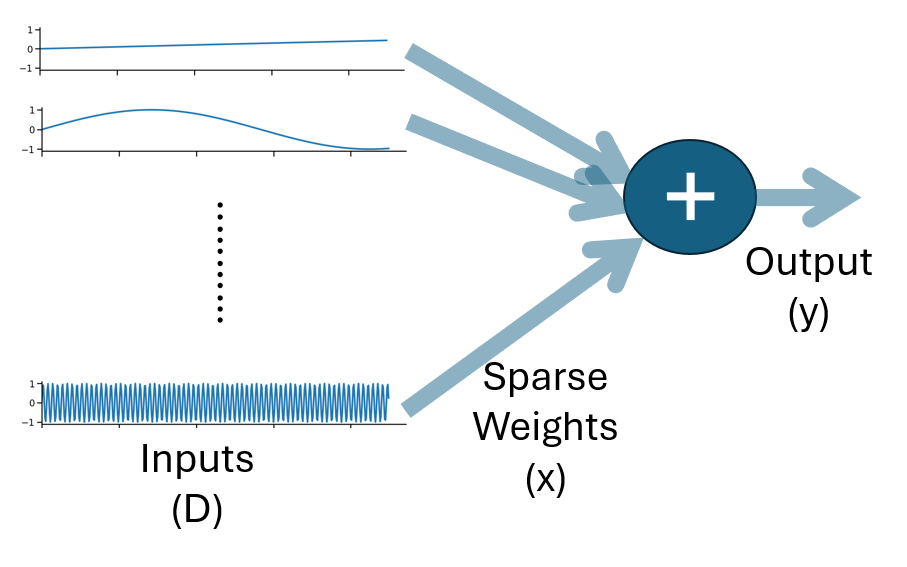



One of the methods to find the sparsest solution for a linear decomposition with $\ell_0$ regaularization is though OMP [1].


[1] Pati, Y. C., Rezaiifar, R., & Krishnaprasad, P. S. (1993, November). Orthogonal matching pursuit: Recursive function approximation with applications to wavelet decomposition. In Proceedings of 27th Asilomar conference on signals, systems and computers (pp. 40-44). IEEE.


In [ ]:
# @title Video 6: OMP

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '1-ERUVsl_A8')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

### Coding Exercise 5A: OMP algorithm

Write the OMP algorithm with increasing sparsity levels to explore how the pixel value are captured by different freqeuencies.



```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete OMP algorithm.")
###################################################################
T_ar = np.arange(len(sig))

# create a set of 20 signals with different frequencies, from 1 to 101, using sin(2\pi f t).
freqs = ...
set_sigs = ...

# define 'reg' --- an sklearn object of OrthogonalMatchingPursuit and fit it to the data, where the frequency bases are the atoms and the signal is the label
reg = OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = 10).fit(np.vstack(set_sigs).T, sig)

```

In [ ]:
#to_remove solution
T_ar = np.arange(len(sig))

# create a set of 20 signals with different frequencies, from 1 to 101, using sin(2\pi f t).
freqs = np.linspace(0.001,1, 100)
set_sigs = [np.sin(f*T_ar) for f in freqs]

# define 'reg' --- an sklearn object of OrthogonalMatchingPursuit and fit it to the data, where the frequency bases are the atoms and the signal is the label
reg = OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = 10).fit(np.vstack(set_sigs).T, sig)

Observe the plot of 3 example signals.

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, axs = plt.subplots(3,1,sharex = True, figsize = (10,5), sharey = True)
    axs[0].plot(set_sigs[0], lw = 3)
    axs[1].plot(set_sigs[1], lw = 3)
    axs[2].plot(set_sigs[-1], lw = 3)
    [remove_edges(ax) for ax in axs]
    [ax.set_xlim(left = 0) for ax in axs]
    fig.tight_layout()

Here we plot prediction and basis operators.

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, axs = plt.subplots(2,2, figsize = (30,20))
    axs = axs.flatten()

    sns.heatmap(np.vstack(set_sigs), ax = axs[0])
    axs[0].set_yticks(np.arange(0,len(freqs)-.5, 4)+ 0.5)
    axs[0].set_yticklabels(['$f = %.4f$'%freqs[int(j)] for j in np.arange(0,len(freqs)-0.5, 4)], rotation = 0)
    add_labels(axs[0], xlabel = 'Time', ylabel= 'Basis Elements', title = 'Frequency Basis Elements')

    axs[1].plot(sig, label = 'Original', lw = 4)
    axs[1].plot(reg.predict(np.vstack(set_sigs).T), lw = 4, label = 'Reconstruction')
    remove_edges(axs[1])
    axs[1].legend()
    add_labels(axs[1], xlabel = 'Time', ylabel= 'Signal', title = 'Reconstruction')
    axs[1].set_xlim(left = 0)

    axs[2].stem(freqs, reg.coef_)
    remove_edges(axs[2])
    add_labels(axs[2], xlabel = 'Frequencies', ylabel= 'Frequency weight', title = 'Frequency Components Contributions')
    axs[2].set_xlim(left = 0)

    num_colors = np.sum(reg.coef_ != 0)
    cmap_name = 'winter'
    samples = np.linspace(0, 1, num_colors)
    colors = plt.colormaps[cmap_name](samples)
    colors_expand = np.zeros((len(reg.coef_), 4))
    colors_expand[reg.coef_!= 0] = np.vstack(colors)

    axs[-1].plot(sig, label = 'Original', color = 'black')
    [axs[-1].plot(reg.coef_[j]*set_sigs[j] + reg.intercept_, label = '$f = %.4f$'%f, lw = 4, color = colors_expand[j]) for j, f in enumerate(freqs) if  reg.coef_[j] != 0]
    remove_edges(axs[-1])
    axs[-1].legend(ncol = 4)
    axs[-1].set_xlim(left = 0)
    add_labels(axs[-1], xlabel = 'Time', ylabel= 'Signal', title = 'Contribution')

### Coding Exercise 5B: Explore the effect of cardinality on the reconstruction

Now we will explore the effect of increasing the cardinality. I.e., increasing the number of non-zero elements in the coefficients.
Below, please run OMP with increasing number of non-zero, coefficiets, from 1 to 101 in intervals ot 5.
We will then compare the accuracy and reconstruction performance of eahc order.

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete computation of cardinalities and then define OMP for each signal.")
###################################################################
# define a list or numpy array of optional cardinallities from 1 to 51 in intervals of 5.
cardinalities = ...

# for each of the optional cardinalities, run OMP using the pixel's signal from before. Create a list called "regs" that include all OMP's fitted objects
regs = ...

```

In [ ]:
#to_remove solution
# define a list or numpy array of optional cardinallities from 1 to 51 in intervals of 5.
cardinalities = np.arange(1,101,5)

# for each of the optional cardinalities, run OMP using the pixel's signal from before. Create a list called "regs" that include all OMP's fitted objects
regs = [OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = card).fit(np.vstack(set_sigs).T, sig) for card in cardinalities]

Now let's observe the effect of the caridnality on the reconstruction.

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize = (20,5))
    ax = axs[0]
    ax.plot(cardinalities, [reg.score(np.vstack(set_sigs).T, sig) for reg in regs], marker = '.')

    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    add_labels(ax, ylabel = 'coefficient of determination', xlabel  = 'Cardinality')
    remove_edges(ax)
    mean_er = np.vstack([np.mean((reg.predict(np.vstack(set_sigs).T) - sig)**2)**0.5 for reg in regs])

    axs[1].plot(cardinalities, mean_er)
    axs[1].set_xlim(left = 0)
    axs[1].set_ylim(bottom = 0)
    remove_edges(axs[1])
    add_labels(axs[1], ylabel = 'rMSE', xlabel  = 'Cardinality')
    plt.show()

What is your conclusion? How do you think the above will affect generalization? How would you define the best cardinality?

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, axs = plt.subplots(5, int(len(cardinalities)/5), figsize = (40,20),sharey = False, sharex = True)
    axs = axs.flatten()
    for j, (ax,reg) in enumerate(zip(axs,regs)):
      ax.stem(freqs, reg.coef_)
      remove_edges(ax)
      add_labels(ax, xlabel = 'Frequencies', ylabel= 'Frequency weight', title = 'Cardinality %d'%cardinalities[j])
      ax.set_xlim(left = 0)
    fig.tight_layout()
    plt.show()

What happen under noise conditions? How sparsity affects generalization? Explore effect under noise.

In [ ]:
noisy_sig = sig + np.random.randn(*sig.shape)*50

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete computation of frequencies and signals.")
###################################################################
T_ar = np.arange(len(sig))

# create a set of 20 signals with different frequencies, from 1 to 101, using sin(2\pi f t).
freqs = ...
set_sigs = ...

dictionary = np.vstack(set_sigs).T

```

In [ ]:
#to_remove solution
T_ar = np.arange(len(sig))

# create a set of 20 signals with different frequencies, from 1 to 101, using sin(2\pi f t).
freqs = np.linspace(0.001,1, 100)
set_sigs = [np.sin(f*T_ar) for f in freqs]

dictionary = np.vstack(set_sigs).T

Let's calculate how increasing the cardinality enables recovering the ground truth (non noisy) signal.

In [ ]:
# least squares solution:
x_hat = np.linalg.pinv(dictionary) @ noisy_sig

# check  cardinalities
regs = [OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = car).fit(dictionary, noisy_sig ) for car in cardinalities]

Check accuracy and correlation with ground truth signal (without noise).

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

predictions = {car:np.mean((reg.predict(dictionary) - sig)**2) for reg,car in zip(regs, cardinalities)}
predictions[dictionary.shape[1]] = np.mean((dictionary @ x_hat - sig)**2)

with plt.xkcd():
    fig, ax = plt.subplots()
    pd.DataFrame(predictions, index = ['Cardinality']).T.plot.bar( ax = ax)
    add_labels(ax, xlabel = 'Cardinality', ylabel = 'MSE', title= 'Extremely Noisy Conditions ($\sigma = 35$)')
    remove_edges(ax)

### Coding Execrcie 5C: Explore the effect of increasing noise levels in the data and the dictionary dictionary

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

# Explore the effect of changing noise levels on generalization
w_noise = 30
w_noise_sig = 0.4

noisy_sig = sig + w_noise*np.random.randn(*sig.shape)
T_ar = np.arange(len(sig))

freqs = np.linspace(0.001,1, 100)
set_sigs = [np.sin(f*T_ar)+ w_noise_sig*np.random.randn(*T_ar.shape) for f in freqs]

dictionary = np.vstack(set_sigs).T

predictions = {car:np.mean((reg.predict(dictionary) - sig)**2) for reg,car in zip(regs, cardinalities)}
predictions[dictionary.shape[1]] = np.mean((dictionary @ x_hat - sig)**2)

with plt.xkcd():
    fig, ax = plt.subplots()
    pd.DataFrame(predictions, index = ['Cardinality']).T.plot.bar( ax = ax)
    add_labels(ax, xlabel = 'Cardinality', ylabel = 'MSE', title= 'Extremely Noisy Conditions \n ($\sigma_{data} = %.2f, \sigma_{dict} = %.2f$)'%(w_noise, w_noise_sig))
    remove_edges(ax)
    ax.set_yscale('log')

Now we are going to change the dictionary. Let's explore the effect of an identity dictionary.

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

# Explore the effect of changing noise levels on generalization
w_noise = 10
w_noise_sig = 0

noisy_sig = sig + w_noise*np.random.randn(*sig.shape)
T_ar = np.arange(len(sig))



dictionary = np.eye(len(sig)).T
# least squares solution:
x_hat = np.linalg.pinv(dictionary) @ noisy_sig

# check  cardinalities
regs = [OrthogonalMatchingPursuit(fit_intercept = True, n_nonzero_coefs = car).fit(dictionary, noisy_sig ) for car in cardinalities]


predictions = {car:np.mean((reg.predict(dictionary) - sig)**2) for reg,car in zip(regs, cardinalities)}
predictions[dictionary.shape[1]] = np.mean((dictionary @ x_hat - sig)**2)

with plt.xkcd():
    fig, ax = plt.subplots()

    pd.DataFrame(predictions, index = ['Cardinality']).T.plot.bar( ax = ax)
    add_labels(ax, xlabel = 'Cardinality', ylabel = 'MSE',
           title= 'Extremely Noisy Conditions \n ($\sigma_{data} = %.2f, \sigma_{dict} = %.2f$)'%(w_noise, w_noise_sig))
    remove_edges(ax)
    ax.set_yscale('log')

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, ax = plt.subplots()
    sns.heatmap(dictionary)
    add_labels(ax, title = 'Identity Dictionary', xlabel = 'Atoms', ylabel = 'Elements')

 Why? Can you explain the results?

# Section 6: Hidden atoms as dictionary learning

Estimated timing to here from start of tutorial: 1 hour 40 minutes. 

In [ ]:
# @title Video 7: Hidden atoms as dictionary learning

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'TGgjedW502E')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Coding Exercise 6

For this section, we first load a new short video created from mnist, as shown below. We then use sklearn's DictionaryLearning to find the dictionary's ($D$) atoms.

### Coding Exercise 6a: Dictionary Learning to find MNIST digits

```python
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete computation of `X_transformed`.")
###################################################################
#make sure you've downloaded these files in `Data retrieval` cell

video_fire = np.load('reweight_digits.npy')
# video_fire is a 3D array representing pixels X pixels X time
# Create a copy of the video_fire array
im_focus = video_fire.copy()

# Get the number of frames in the video
T = im_focus.shape[2]

# Get the number of rows in the video
N0 = im_focus.shape[0]

# Get the number of columns in the video, leaving out 10 columns
N1 = im_focus.shape[1] - 10

# Create a copy of the extracted frames
low_res = im_focus.copy()

# Get the shape of a single frame
shape_frame = low_res[:, :, 0].shape

# Flatten each frame and store them in a list
video_fire_ar = [low_res[:, :, frame].flatten() for frame in range(low_res.shape[2])]
# Create dict_learner object

dict_learner = DictionaryLearning(
    n_components=20, transform_algorithm='lasso_lars', transform_alpha=0.3,
    random_state=42,
)

X_transformed = dict_learner.fit(...).transform(...)

```

In [ ]:
#to_remove solution
#make sure you've downloaded these files in `Data retrieval` cell

video_fire = np.load('reweight_digits.npy')
# video_fire is a 3D array representing pixels X pixels X time
# Create a copy of the video_fire array
im_focus = video_fire.copy()

# Get the number of frames in the video
T = im_focus.shape[2]

# Get the number of rows in the video
N0 = im_focus.shape[0]

# Get the number of columns in the video, leaving out 10 columns
N1 = im_focus.shape[1] - 10

# Create a copy of the extracted frames
low_res = im_focus.copy()

# Get the shape of a single frame
shape_frame = low_res[:, :, 0].shape

# Flatten each frame and store them in a list
video_fire_ar = [low_res[:, :, frame].flatten() for frame in range(low_res.shape[2])]
# Create dict_learner object

dict_learner = DictionaryLearning(
    n_components=20, transform_algorithm='lasso_lars', transform_alpha=0.3,
    random_state=42,
)

X_transformed = dict_learner.fit(np.vstack(video_fire_ar)).transform(np.vstack(video_fire_ar))

Let's visualize atoms!

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    num_thetas = 20
    cmap_name = 'plasma'
    samples = np.linspace(0, 1, len(dict_learner.components_)+1)
    colors = plt.colormaps[cmap_name](samples)

    num_comps = len(dict_learner.components_)

    fig, axs = plt.subplots(2, int(num_comps/2) , figsize = (50,15), sharey = True, sharex = True)
    axs = axs.flatten()
    [sns.heatmap(dict_learner.components_[j].reshape(shape_frame), ax = axs[j]) for j in range(num_comps)]
    titles = ['Atom %d'%j for j in range(1, num_comps +1)]
    [ax.set_title(title, color = colors[j], fontsize = 40)
    for j, (title, ax) in enumerate(zip(titles, axs))]

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

import warnings
warnings.filterwarnings("ignore")

with plt.xkcd():
    fig, ax = plt.subplots()
    [ax.plot(X_transformed[:,j], color = colors[j], lw = 5, label = 'Atom %d'%(j+1))
     for j in range(num_comps)]
    remove_edges(ax)
    ax.set_xlim(left = 0)
    [ax.set_yticks([]) for ax in axs]
    [ax.set_xticks([]) for ax in axs]

    add_labels(ax, xlabel = 'Time', ylabel = 'Coefficients', title = 'Elements Ceofficients')
    create_legend({'Atom %d'%(j+1): colors[j] for j in range(num_comps)}, params_leg = {'ncol': 5})

Now, let's compare the components to PCA.

In [ ]:
data_mat = np.vstack(video_fire_ar)
# Assuming your data is stored in a variable named 'data_mat' (N by p numpy array)
# where N is the number of samples and p is the number of features

# Create a PCA object with 20 components
pca = PCA(n_components=20)

# Fit the PCA model to the data
pca.fit(data_mat)

# Access the 20 PCA components
pca_components = pca.components_

pca_componens_images = [pca_components[comp,:].reshape(shape_frame) for comp in range(num_comps)]

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

with plt.xkcd():
    fig, axs = plt.subplots(2, int(num_comps/2) , figsize = (50,15), sharey = True, sharex = True)
    axs = axs.flatten()
    [sns.heatmap(im, ax = axs[j]) for j,im in enumerate(pca_componens_images)]
    titles = ['Atom %d'%j for j in range(1, num_comps +1)]
    [ax.set_title(title, color = colors[j], fontsize = 40)
    for j, (title, ax) in enumerate(zip(titles, axs))]